# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h1>Applying Naive Bayes on Amazon Fine Food Reviews</h1>

<p> 
Tried to Apply Naive Bayes on Amazon Fine Food Reviews text data as Naive Bayes is the benchmark
algorithm for text processing algorithm.Also tried Feature Engineering techniques to improve the AUC value 
</p>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.patches as mpatches
from math import log
import re
import nltk
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

In [4]:
#Reading data from database
con = sqlite3.connect('final.sqlite') 
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [3]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [5]:
row_list = list(np.random.choice(data.shape[0], int(100000), replace=False))
total_data = data.iloc[row_list]
print("Shape of dataset", total_data.shape)

In [7]:
#Saving the 6k dataset in a pickle file
total_data.to_pickle('./naive_bayes_data.pkl')

In [4]:
#Reading the 6K dataset from the pickle file
total_data = pd.read_pickle("./naive_bayes_data.pkl")
labels = total_data['Score']
print("labels shape",labels.shape)

labels shape (100000,)


In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y) 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sn.light_palette("blue")
    plt.subplot(1, 3, 1)
    sn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [6]:
#Performing data cleaning of the summary text of the data
final_string=[]
for i, sent in enumerate(tqdm(total_data['Summary'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (total_data['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(total_data['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
total_data['CleanedSummaryText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
total_data['CleanedSummaryText']=total_data['CleanedSummaryText'].str.decode("utf-8")

100%|██████████| 100000/100000 [00:08<00:00, 12432.50it/s]


In [7]:
labels = labels.replace('positive', 1)
labels = labels.replace('negative', 0)

In [8]:
#Splitting the total data into train, test and cross-validation data
#Splitup Proportion : Train data - 60%, Cross-Validation - 20%, Test data - 20%
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(total_data['CleanedText'].values, labels, test_size=0.4)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_train shape", Y_train.shape)
print("Y_test shape", Y_test.shape)
print("="*40)
X_test, X_cv, Y_test, Y_cv = train_test_split(X_test, Y_test, test_size=0.5)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_cv shape", X_cv.shape)
print("Y_cv shape", Y_cv.shape)
print("-"*40)
print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)

X_train shape (60000,)
X_test shape (40000,)
Y_train shape (60000,)
Y_test shape (40000,)
X_test shape (20000,)
Y_test shape (20000,)
X_cv shape (20000,)
Y_cv shape (20000,)
----------------------------------------
X_train shape (60000,)
Y_train shape (60000,)


In [9]:
#Splitting summary text data into train, cross validation and test data 
from sklearn.model_selection import train_test_split
X_train_summary, X_test_summary, _ , label_test = train_test_split(total_data['CleanedSummaryText'].values, labels, test_size=0.4)
print("X_train shape", X_train_summary.shape)
print("X_test shape", X_test_summary.shape)
print("="*40)
X_test_summary, X_cv_summary, _ , _ = train_test_split(X_test_summary, label_test , test_size=0.5)
print("X_test shape", X_test_summary.shape)
print("X_cv shape", X_cv_summary.shape)
print("X_train shape", X_train_summary.shape)

X_train shape (60000,)
X_test shape (40000,)
X_test shape (20000,)
X_cv shape (20000,)
X_train shape (60000,)


In [10]:
#finding length of review text for train, test and cross validation data
text_len_train = []
text_len_cv = []
text_len_test = []
for each in X_train:
    text_len_train.append(len(each.split()))
for each in X_cv:
    text_len_cv.append(len(each.split()))
for each in X_test:
    text_len_test.append(len(each.split()))

In [11]:
print(len(text_len_train))
print(len(text_len_cv))
print(len(text_len_test))

60000
20000
20000


# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [12]:
#Converting the text data in the 200000 data points to BOW Vectors
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
features_list = count_vect.get_feature_names()

After vectorizations
(60000, 6729) (60000,)
(20000, 6729) (20000,)
(20000, 6729) (20000,)


In [13]:
#Taking the list of hyperparameter in which the model must be trained
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [14]:
#Grid-Search on the hyperparameters
tuned_parameters = [{'alpha': alpha}]
#Using Multinomial Naive bayes
grid_model = GridSearchCV(naive_bayes.MultinomialNB(class_prior = [0.5, 0.5]), tuned_parameters, scoring = 'roc_auc', cv=5)
grid_model.fit(X_train_bow, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [15]:
#The Best Hyper-parameter
print(grid_model.best_estimator_)
print("Score", grid_model.score(X_cv_bow, Y_cv))
print("Best Hyper-parameter", grid_model.best_params_)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)
Score 0.915823970422078
Best Hyper-parameter {'alpha': 1}


In [16]:
#Cross Validation to find the best alpha value
#Iteratively training the Naive Bayes model for best alpha value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    clf = naive_bayes.MultinomialNB(alpha=a, class_prior = [0.5, 0.5])
    clf.fit(X_train_bow, Y_train)
    y_pred = clf.predict_proba(X_train_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_bow)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(a)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", a, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9343361364432741 Roc CV 0.8949650156921427
Executing 0.0001 Roc Train 0.9341400001803407 Roc CV 0.8984407490298577
Executing 0.001 Roc Train 0.9338114172872519 Roc CV 0.9023718291180169
Executing 0.01 Roc Train 0.9332155222614895 Roc CV 0.9067895968819126
Executing 0.1 Roc Train 0.9320967911723635 Roc CV 0.911892386368797
Executing 1 Roc Train 0.9291402308487066 Roc CV 0.915823970422078
Executing 10 Roc Train 0.9101529824056656 Roc CV 0.9029219783639595
Executing 100 Roc Train 0.7078419558915952 Roc CV 0.7105476514806952
Executing 1000 Roc Train 0.5650215685406934 Roc CV 0.5685626100783439
Executing 10000 Roc Train 0.541810803290002 Roc CV 0.547970747354031


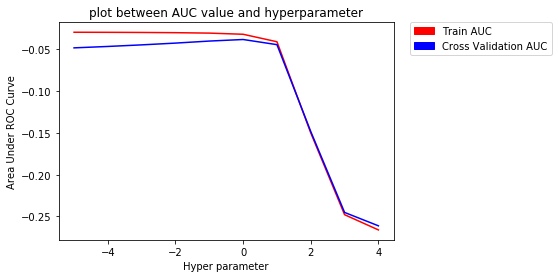

In [17]:
#Plotting the hyperparameter Vs AUC for train and cross validation data
y_axis_train_log = []
y_axis_cv_log = []
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
for each in y_axis_train:
    y_axis_train_log.append(log(each, 10))
for each in y_axis_cv:
    y_axis_cv_log.append(log(each, 10))
#Plot between AUC and hyperparameter for Validation data and training data
plt.plot(x_axis_log, y_axis_train_log, color='red')
plt.plot(x_axis_log, y_axis_cv_log, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In the above hyperparameter vs roc curve, both train and cross validation attain a maximum value as well as have a
minimum difference at log(alpha) = 1 which is at 10.Hence the optimum hyperparamter choosen is 10

In [18]:
#Training the Multinomial naive bayes Model with the best hyperparameter
model = naive_bayes.MultinomialNB(alpha=10, class_prior = [0.5, 0.5])
model.fit(X_train_bow, Y_train)

MultinomialNB(alpha=10, class_prior=[0.5, 0.5], fit_prior=True)

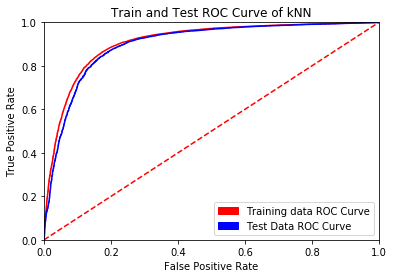

In [19]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_bow)
y_pred_train = model.predict(X_train_bow)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_bow)
y_pred_test = model.predict(X_test_bow)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.8994157654803658
The AUC of the train data is 0.9101529824056656
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


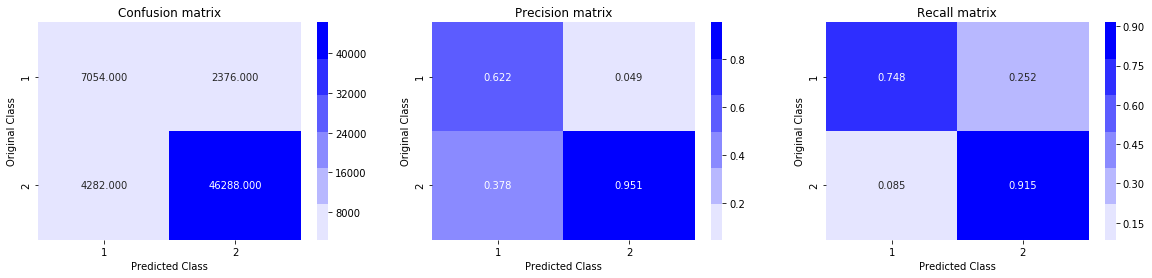

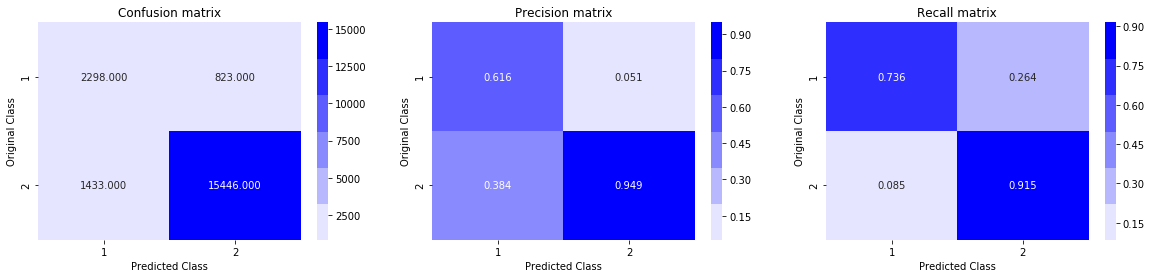

In [20]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

<h3>Training Naive Bayes Model with Feature Engineered BOW Data</h3>

<p>
Feature engineered data has review summary text, and length of the review summary as additional features
</p>

In [21]:
#Converting the text data in the 200000 data points to BOW Vectors
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)

After vectorizations
(60000, 6729) (60000,)
(20000, 6729) (20000,)
(20000, 6729) (20000,)


In [22]:
#Appending length of the review text to review text BOW vector
X_train_bow = X_train_bow.todense()
print(type(X_train_bow))
text_len_train_col = np.array(text_len_train).reshape(60000, 1)
print(type(text_len_train_col))
print(text_len_train_col.shape)
X_train_bow = np.hstack((X_train_bow, text_len_train_col))
print(type(X_train_bow))
print(X_train_bow.shape)
X_cv_bow = X_cv_bow.todense()
print(type(X_cv_bow))
text_len_cv_col = np.array(text_len_cv).reshape(20000, 1)
print(type(text_len_cv_col))
print(text_len_cv_col.shape)
X_cv_bow = np.hstack((X_cv_bow, text_len_cv_col))
print(type(X_cv_bow))
print(X_cv_bow.shape)
X_test_bow = X_test_bow.todense()
print(type(X_test_bow))
text_len_test_col = np.array(text_len_test).reshape(20000, 1)
print(type(text_len_test_col))
print(text_len_test_col.shape)
X_test_bow = np.hstack((X_test_bow, text_len_test_col))
print(type(X_test_bow))
print(X_test_bow.shape)

<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(60000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(60000, 6730)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(20000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(20000, 6730)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(20000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(20000, 6730)


In [23]:
#Converting the summary of review text data in the 100000 data points to BOW Vectors
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_train_bow2 = count_vect.fit_transform(X_train_summary)
X_cv_bow2 = count_vect.transform(X_cv_summary)
X_test_bow2 = count_vect.transform(X_test_summary)
print("After vectorizations")
print(X_train_bow2.shape)
print(X_cv_bow2.shape)
print(X_test_bow2.shape)
X_train_bow2 = X_train_bow2.todense()
X_cv_bow2 = X_cv_bow2.todense()
X_test_bow2 = X_test_bow2.todense()

After vectorizations
(60000, 1700)
(20000, 1700)
(20000, 1700)


In [24]:
#Appending summary review test BOW to the original BOW vectors
X_train_final = np.hstack((X_train_bow, X_train_bow2))
X_cv_final = np.hstack((X_cv_bow, X_cv_bow2))
X_test_final = np.hstack((X_test_bow, X_test_bow2))
print(X_train_final.shape)
print(X_cv_final.shape)
print(X_test_final.shape)

(60000, 8430)
(20000, 8430)
(20000, 8430)


In [25]:
#Taking the list of hyperparameter in which the model must be trained
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [26]:
#Grid-Search on the hyperparameters
tuned_parameters = [{'alpha': alpha}]
#Using Multinomial Naive bayes
grid_model = GridSearchCV(naive_bayes.MultinomialNB(class_prior = [0.5, 0.5]), tuned_parameters, scoring = 'roc_auc', cv=5)
grid_model.fit(X_train_final, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
#The Best Hyper-parameter
print(grid_model.best_estimator_)
print("Score", grid_model.score(X_cv_final, Y_cv))
print("Best Hyper-parameter", grid_model.best_params_)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)
Score 0.9145995443698881
Best Hyper-parameter {'alpha': 1}


In [28]:
#Cross Validation to find the best alpha value
#Iteratively training the Naive Bayes model for best alpha value 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    clf = naive_bayes.MultinomialNB(alpha=a, class_prior = [0.5, 0.5])
    clf.fit(X_train_final, Y_train)
    y_pred = clf.predict_proba(X_train_final)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_final)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(a)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", a, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9386384569041245 Roc CV 0.8847863085190036
Executing 0.0001 Roc Train 0.9383954372958454 Roc CV 0.8902228940742907
Executing 0.001 Roc Train 0.9379831448528136 Roc CV 0.896469636843114
Executing 0.01 Roc Train 0.9372403214174949 Roc CV 0.9030611107725987
Executing 0.1 Roc Train 0.9358302016607704 Roc CV 0.9098957906627017
Executing 1 Roc Train 0.9320202711359851 Roc CV 0.9145995443698881
Executing 10 Roc Train 0.9040860405586285 Roc CV 0.8933146725508493
Executing 100 Roc Train 0.5996240304851312 Roc CV 0.5997152711168803
Executing 1000 Roc Train 0.5007068024730166 Roc CV 0.4959898639491954
Executing 10000 Roc Train 0.48072864257328596 Roc CV 0.4791256981057985


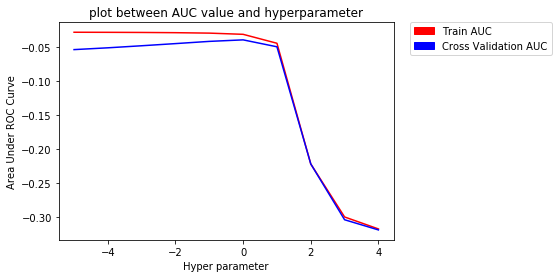

In [29]:
#Plotting the hyperparameter Vs AUC for train and cross validation data
y_axis_train_log = []
y_axis_cv_log = []
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
for each in y_axis_train:
    y_axis_train_log.append(log(each, 10))
for each in y_axis_cv:
    y_axis_cv_log.append(log(each, 10))
#Plot between AUC and hyperparameter for Validation data and training data
plt.plot(x_axis_log, y_axis_train_log, color='red')
plt.plot(x_axis_log, y_axis_cv_log, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In the above hyperparameter vs roc curve, both train and cross validation attain a maximum value as well as have a
minimum difference at log(alpha) = 1 which is at 10.Hence the optimum hyperparamter choosen is 10

In [30]:
#Training the Multinomial naive bayes Model with the best hyperparameter
model_feat_engg = naive_bayes.MultinomialNB(alpha=10, class_prior = [0.5, 0.5])
model_feat_engg.fit(X_train_final, Y_train)

MultinomialNB(alpha=10, class_prior=[0.5, 0.5], fit_prior=True)

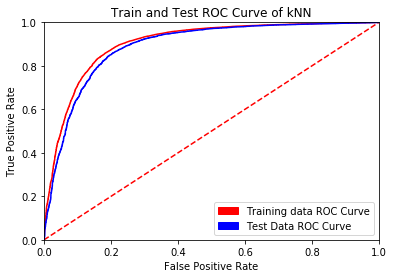

In [31]:
#Plotting the ROC Curve on both train and test data
y_scores = model_feat_engg.predict_proba(X_train_final)
y_pred_train = model_feat_engg.predict(X_train_final)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model_feat_engg.predict_proba(X_test_final)
y_pred_test = model_feat_engg.predict(X_test_final)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.8901354228702747
The AUC of the train data is 0.9040860405586285
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


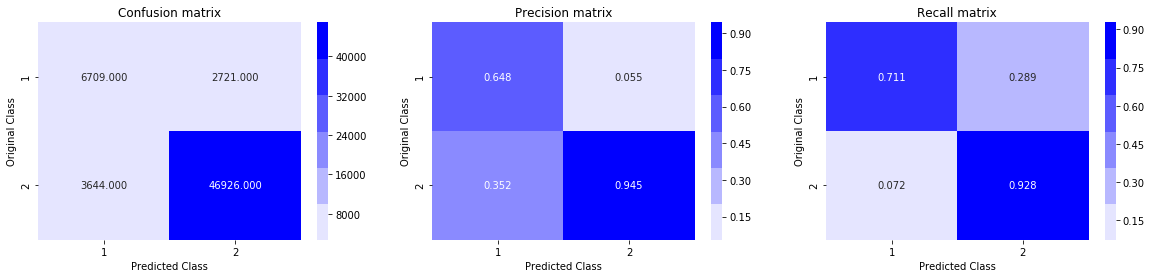

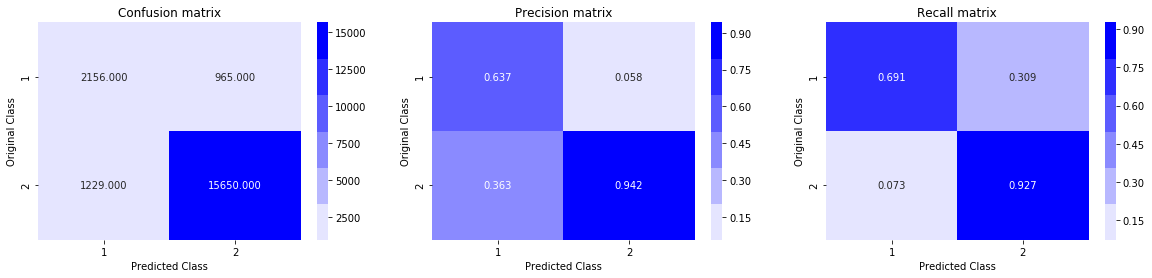

In [32]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [33]:
max_ind_pos=np.argsort((model.feature_log_prob_)[1])[::-1][0:10] 
print("Top 10 positive features:")
for each in max_ind_pos:
    print(features_list[each-1])

Top 10 positive features:
lightweight
tassimo
goo
flavacol
lousi
usda
greasi
omnivor
produc
trend


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation
max_ind_neg=np.argsort((model.feature_log_prob_)[0])[::-1][0:10] 
print("Top 10 negative features:")
for each in max_ind_neg:
    print(features_list[each-1])

Top 10 negative features:
tassimo
lightweight
produc
omnivor
flavacol
worthwhil
trend
goo
coff
usda


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [35]:
#Converting the text data in the 100000 data points to TF-IDF Vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df = 10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_cv_vec = tf_idf_vect.transform(X_cv)
X_test_vec = tf_idf_vect.transform(X_test)
print("After vectorizations")
print(X_train_vec.shape, Y_train.shape)
print(X_cv_vec.shape, Y_cv.shape)
print(X_test_vec.shape, Y_test.shape)
feature_list = tf_idf_vect.get_feature_names()

After vectorizations
(60000, 6729) (60000,)
(20000, 6729) (20000,)
(20000, 6729) (20000,)


In [36]:
#Taking the list of hyperparameter in which the model must be trained
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [37]:
#Grid-Search on the hyperparameters
tuned_parameters = [{'alpha': alpha}]
#Using Multinomial Naive bayes
grid_model = GridSearchCV(naive_bayes.MultinomialNB(class_prior = [0.5, 0.5]), tuned_parameters, scoring = 'roc_auc', cv=5)
grid_model.fit(X_train_vec, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
#The Best Hyper-parameter
print(grid_model.best_estimator_)
print("Score", grid_model.score(X_cv_vec, Y_cv))
print("Best Hyper-parameter", grid_model.best_params_)

MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=True)
Score 0.9235386970284163
Best Hyper-parameter {'alpha': 0.1}


In [39]:
#Cross Validation to find the best alpha value
#Iteratively training the naive bayes model for alpha 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    clf = naive_bayes.MultinomialNB(alpha=a, class_prior = [0.5, 0.5])
    clf.fit(X_train_vec, Y_train)
    y_pred = clf.predict_proba(X_train_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_vec)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(a)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", a, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9478002825058385 Roc CV 0.9008638608779369
Executing 0.0001 Roc Train 0.947656645314465 Roc CV 0.904733495256376
Executing 0.001 Roc Train 0.947386092291252 Roc CV 0.9094063359331848
Executing 0.01 Roc Train 0.9468155907070845 Roc CV 0.9159192008124907
Executing 0.1 Roc Train 0.9451539522612944 Roc CV 0.9235386970284163
Executing 1 Roc Train 0.9346663528877897 Roc CV 0.9224356600090783
Executing 10 Roc Train 0.8695913531656402 Roc CV 0.8659210493185212
Executing 100 Roc Train 0.7323166411917922 Roc CV 0.7395083590127336
Executing 1000 Roc Train 0.6794681385125791 Roc CV 0.691171904138455
Executing 10000 Roc Train 0.6676012052212414 Roc CV 0.680729499592682


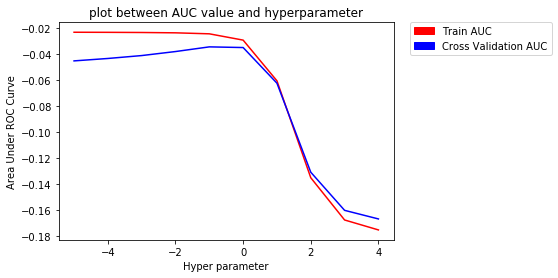

In [40]:
#Plotting the hyperparameter Vs AUC for train and cross validation data
y_axis_train_log = []
y_axis_cv_log = []
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
for each in y_axis_train:
    y_axis_train_log.append(log(each, 10))
for each in y_axis_cv:
    y_axis_cv_log.append(log(each, 10))
#Plot between AUC and hyperparameter for Validation data and training data
plt.plot(x_axis_log, y_axis_train_log, color='red')
plt.plot(x_axis_log, y_axis_cv_log, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In this hyperparameter vs AUC curve, both train and test data have high AUC infact the AUC(with the very 
less difference as noticeable in the plot)at log(alpha) = 0 which is alpha = 1

In [41]:
#Training the Multinomial naive bayes Model with the best hyperparameter
model = naive_bayes.MultinomialNB(alpha=1, class_prior = [0.5, 0.5])
model.fit(X_train_vec, Y_train)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)

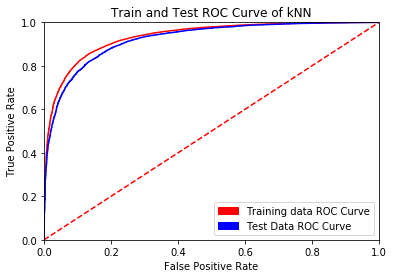

In [42]:
#Plotting the ROC Curve on both train and test data
y_scores = model.predict_proba(X_train_vec)
y_pred_train = model.predict(X_train_vec)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model.predict_proba(X_test_vec)
y_pred = model.predict(X_test_vec)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9222197255665165
The AUC of the train data is 0.9346663528877897
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


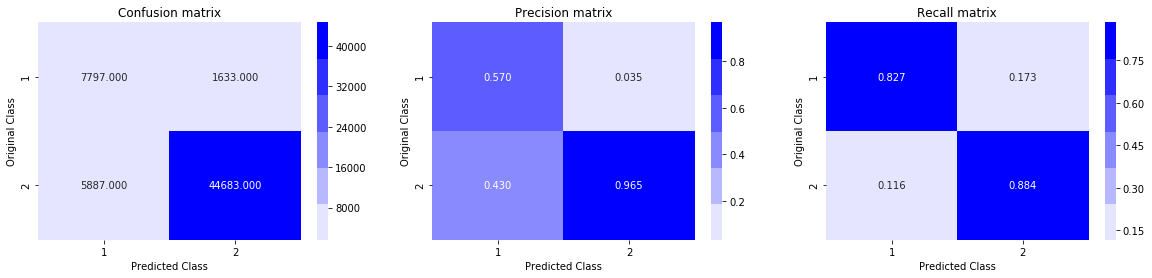

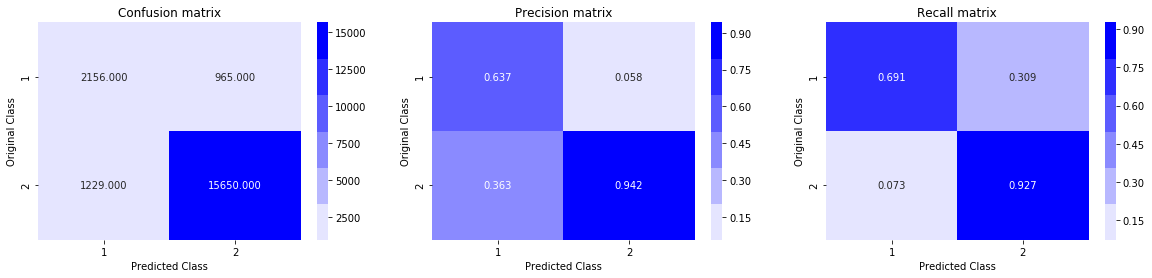

In [43]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

<h3>Training Naive Bayes Model with Feature Engineered TF_IDF Data</h3>

In [44]:
#Appending length of the review text to review text TF_IDF vector
X_train_vec = X_train_vec.todense()
print(type(X_train_vec))
text_len_train_col = np.array(text_len_train).reshape(60000, 1)
print(type(text_len_train_col))
print(text_len_train_col.shape)
X_train_vec = np.hstack((X_train_vec, text_len_train_col))
print(type(X_train_vec))
print(X_train_vec.shape)
X_cv_vec = X_cv_vec.todense()
print(type(X_cv_vec))
text_len_cv_col = np.array(text_len_cv).reshape(20000, 1)
print(type(text_len_cv_col))
print(text_len_cv_col.shape)
X_cv_vec = np.hstack((X_cv_vec, text_len_cv_col))
print(type(X_cv_vec))
print(X_cv_vec.shape)
X_test_vec = X_test_vec.todense()
print(type(X_test_vec))
text_len_test_col = np.array(text_len_test).reshape(20000, 1)
print(type(text_len_test_col))
print(text_len_test_col.shape)
X_test_vec = np.hstack((X_test_vec, text_len_test_col))
print(type(X_test_vec))
print(X_test_vec.shape)

<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(60000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(60000, 6730)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(20000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(20000, 6730)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>
(20000, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
(20000, 6730)


In [45]:
#Converting the summary of review text data in the 100000 data points to TF_IDF Vectors
tf_idf_vect = TfidfVectorizer(min_df = 10)  #in scikit-learn
X_train_vec2 = tf_idf_vect.fit_transform(X_train_summary)
X_cv_vec2 = tf_idf_vect.transform(X_cv_summary)
X_test_vec2 = tf_idf_vect.transform(X_test_summary)
print("After vectorizations")
print(X_train_vec2.shape)
print(X_cv_vec2.shape)
print(X_test_vec2.shape)
X_train_vec2 = X_train_vec2.todense()
X_cv_vec2 = X_cv_vec2.todense()
X_test_vec2 = X_test_vec2.todense()

After vectorizations
(60000, 1700)
(20000, 1700)
(20000, 1700)


In [46]:
#Appending summary review test Tf-idf vector to the original tf-idf vectors
X_train_final = np.hstack((X_train_vec, X_train_vec2))
X_cv_final = np.hstack((X_cv_vec, X_cv_vec2))
X_test_final = np.hstack((X_test_vec, X_test_vec2))
print(X_train_final.shape)
print(X_cv_final.shape)
print(X_test_final.shape)

(60000, 8430)
(20000, 8430)
(20000, 8430)


In [47]:
#Grid-Search on the hyperparameters
tuned_parameters = [{'alpha': alpha}]
#Using Multinomial Naive bayes
grid_model = GridSearchCV(naive_bayes.MultinomialNB(class_prior = [0.5, 0.5]), tuned_parameters, scoring = 'roc_auc', cv=5)
grid_model.fit(X_train_final, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
#The Best Hyper-parameter
print(grid_model.best_estimator_)
print("Score", grid_model.score(X_cv_final, Y_cv))
print("Best Hyper-parameter", grid_model.best_params_)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)
Score 0.9089471381285101
Best Hyper-parameter {'alpha': 1}


In [49]:
#Cross Validation to find the best alpha value
#Iteratively training the Naive Bayes model for alpha 
x_axis = []
y_axis_train = []
y_axis_cv = []
for a in alpha:
    clf = naive_bayes.MultinomialNB(alpha=a, class_prior = [0.5, 0.5])
    clf.fit(X_train_final, Y_train)
    y_pred = clf.predict_proba(X_train_final)[:,1]
    fpr, tpr, _ = roc_curve(Y_train, y_pred)
    roc_auc_train = auc(fpr, tpr)
    y_pred = clf.predict_proba(X_cv_final)[:,1]
    fpr, tpr, _ = roc_curve(Y_cv, y_pred)
    roc_auc_cv = auc(fpr, tpr)
    x_axis.append(a)
    y_axis_train.append(roc_auc_train)
    y_axis_cv.append(roc_auc_cv)
    print("Executing", a, "Roc Train", roc_auc_train, "Roc CV", roc_auc_cv)

Executing 1e-05 Roc Train 0.9474072665987384 Roc CV 0.8728441227891811
Executing 0.0001 Roc Train 0.9470461825329106 Roc CV 0.8763191810038089
Executing 0.001 Roc Train 0.9464913663976166 Roc CV 0.8809136503498354
Executing 0.01 Roc Train 0.9456163616007629 Roc CV 0.8886428017691801
Executing 0.1 Roc Train 0.9442998973945169 Roc CV 0.901100001818078
Executing 1 Roc Train 0.9350783213466167 Roc CV 0.9089471381285101
Executing 10 Roc Train 0.6356846488734682 Roc CV 0.630767719166444
Executing 100 Roc Train 0.4770108200239434 Roc CV 0.47653821755790143
Executing 1000 Roc Train 0.46837509968543134 Roc CV 0.46818149643941986
Executing 10000 Roc Train 0.4707463830676 Roc CV 0.467467843792264


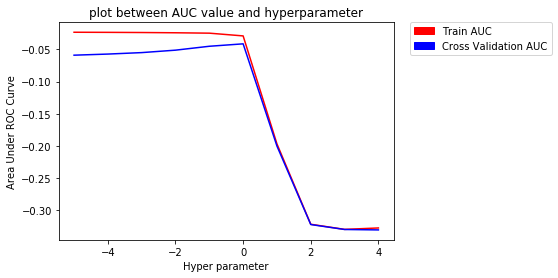

In [50]:
#Plotting the hyperparameter Vs AUC for train and cross validation data
y_axis_train_log = []
y_axis_cv_log = []
x_axis_log = []
for each in x_axis:
    x_axis_log.append(round(log(each, 10)))
for each in y_axis_train:
    y_axis_train_log.append(log(each, 10))
for each in y_axis_cv:
    y_axis_cv_log.append(log(each, 10))
#Plot between AUC and hyperparameter for Validation data and training data
plt.plot(x_axis_log, y_axis_train_log, color='red')
plt.plot(x_axis_log, y_axis_cv_log, color='blue')
plt.title('plot between AUC value and hyperparameter')
blue_patch = mpatches.Patch(color='blue', label='Cross Validation AUC')
red_patch = mpatches.Patch(color='red', label='Train AUC')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under ROC Curve')
plt.show()

In [ ]:
Observation:
    In this hyperparameter vs AUC curve, both train and test data have high AUC infact the AUC(with the very 
less difference as noticeable in the plot) at log(alpha) = 0 which is alpha = 1

In [51]:
#Training the Multinomial naive bayes Model with the best hyperparameter
model_feat_engg = naive_bayes.MultinomialNB(alpha=1, class_prior = [0.5, 0.5])
model_feat_engg .fit(X_train_final, Y_train)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)

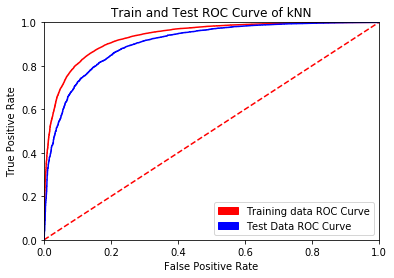

In [52]:
#Plotting the ROC Curve on both train and test data
y_scores = model_feat_engg.predict_proba(X_train_final)
y_pred_train = model_feat_engg.predict(X_train_final)
train_fpr, train_tpr, threshold = roc_curve(Y_train, y_scores[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, color='red')
blue_patch = mpatches.Patch(color='blue', label='Test Data ROC Curve')
red_patch = mpatches.Patch(color='red', label='Training data ROC Curve')
plt.legend(handles=[red_patch, blue_patch], loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train and Test ROC Curve of kNN')

y_scores = model_feat_engg.predict_proba(X_test_final)
y_pred = model_feat_engg.predict(X_test_final)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue')
plt.show()

The AUC of the test data is 0.9055710605742184
The AUC of the train data is 0.9350783213466167
The confusion matrix, Recall and precision matrix for train data:
The confusion matrix, Recall and precision matrix for test data:


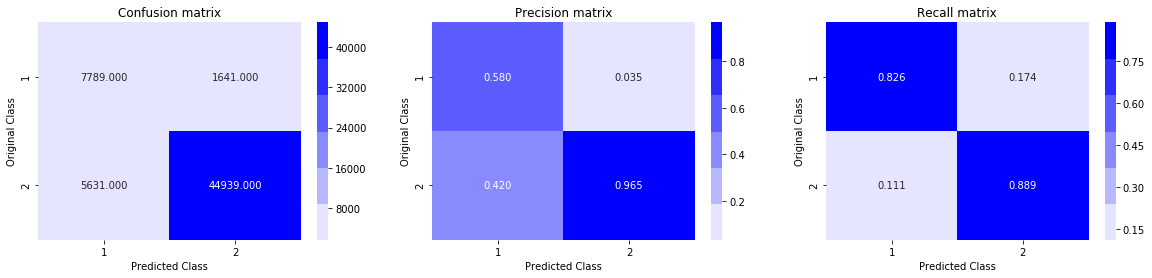

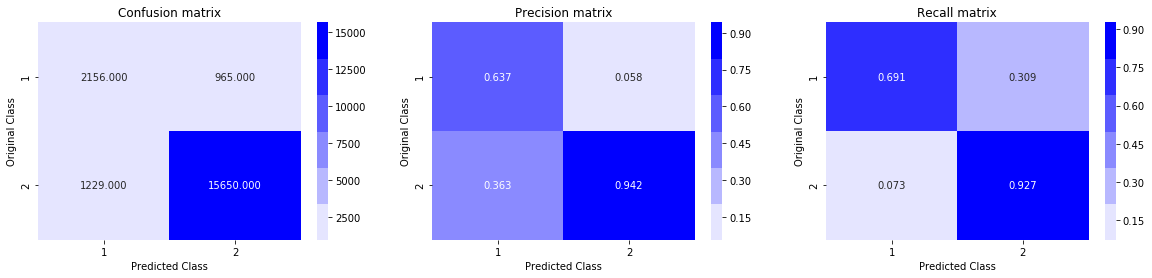

In [53]:
#Test Data AUC Value and Confusion matrix for test data and train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
print("The AUC of the test data is", test_roc_auc)
print("The AUC of the train data is", train_roc_auc)
print("The confusion matrix, Recall and precision matrix for train data:")
print("The confusion matrix, Recall and precision matrix for test data:")
plot_confusion_matrix(Y_train, y_pred_train)
plot_confusion_matrix(Y_test, y_pred_test)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [55]:
#https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
max_ind_pos=np.argsort((model.feature_log_prob_)[1])[::-1][0:10] 
print("Top 10 positive features:")
for each in max_ind_pos:
    print(features_list[each-1])

Top 10 positive features:
lousi
greasi
goo
tassimo
lightweight
flavacol
tbsp
coff
produc
usda


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [56]:
# Please write all the code with proper documentation
max_ind_neg=np.argsort((model.feature_log_prob_)[0])[::-1][0:10] 
print("Top 10 negative features:")
for each in max_ind_neg:
    print(features_list[each-1])

Top 10 negative features:
tassimo
produc
lightweight
coff
worthwhil
flavacol
omnivor
button
orchid
trend


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [63]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Type", "Hyper Parameter", "Test AUC", "Recall - class 1 & 2", "Precision - class 1 & 2"]
x.add_row(["BOW model-\n without feature engineering\n", 10, 0.8994157654803658 ,[0.736 , 0.915] ,[0.616, 0.949] ] )
x.add_row(["BOW model-\nwith feature engineering\n", 10, 0.8901354228702747 , [0.691 , 0.927], [0.637, 0.942] ] )
x.add_row(["TF-IDF model-\nwithout feature engineering\n", 1, 0.9222197255665165 ,[0.691 , 0.927] ,[0.637, 0.942] ] )
x.add_row(["TF-IDF model-\nwith feature engineering\n", 1, 0.9055710605742184 , [0.691 , 0.927], [0.637, 0.942] ] )
print(x)

+------------------------------+-----------------+--------------------+----------------------+-------------------------+
|             Type             | Hyper Parameter |      Test AUC      | Recall - class 1 & 2 | Precision - class 1 & 2 |
+------------------------------+-----------------+--------------------+----------------------+-------------------------+
|          BOW model-          |        10       | 0.8994157654803658 |    [0.736, 0.915]    |      [0.616, 0.949]     |
|  without feature engineering |                 |                    |                      |                         |
|                              |                 |                    |                      |                         |
|          BOW model-          |        10       | 0.8901354228702747 |    [0.691, 0.927]    |      [0.637, 0.942]     |
|   with feature engineering   |                 |                    |                      |                         |
|                              |

<h6>Final Observation:</h6>
<p>
1) In naive bayes model trained with BOW based vectorized data, Naive bayes gives a phenomenal auc value for 
both test and train data.As observed from the above table, it gives a very good 0.915 recall value for class 2 
and a little less yet a good recall value of 0.736 for class 2.This very good auc and recall value may be due to 
naive bayes inherent nature of performing very good in text based classification.A feature engineering is tried 
to furthur improve the recall rate of class 1
</p>
<p>
2) As noticed from above tabulation, AUC value of test data falls a little bit in the model trained with feature 
engineered data.Not only the AUC recall value of class 1 reduces a bit while that of class 2 increased a bit.This may 
have happened because model overfits slightly on feature engineered data and new features are not very useful.
Thus feature engineering failed in this case.
</p>
<p>
3)  Naive bayes model based on TF-IDF data performs very good AUC of 0.9222197255665165 which is higher than that of
the bow based naive bayes model.but considering recall values of both models, recall values of class 1 falls 
slightly while that of the class 2 has increased slightly compared to previous model.This may be because the 
model is slightly overfitting than the previous one.
</p>
<p>
4)Feature engineering on tf-idf data is also not very useful as auc fell from 0.92 to 0.90 in feature engineered data.
Thus feature engineering is also not useful here
</p>

<h6>
Final Observation:
Naive bayes performs very good in this problem and gives a very good AUC and recall values for both classes.But feature
engineering is not very useful as it neither improved AUC and recall values of both the classes
</h6>